In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

import gensim
import pyLDAvis.gensim

from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data= pd.read_csv('trial_data.csv')
data.head()

,id,text,is_humor_all,funniness_all,funniness_female,funniness_male,funniness_18_25,funniness_26_40,funniness_41_55,funniness_56_70,...,is_off_male,offense_male,is_off_18_25,offense_18_25,is_off_26_40,offense_26_40,is_off_41_55,offense_41_55,is_off_56_70,offense_56_70
0,1,It's been confirmed by People Magazine that Br...,1,2.188,2.188,2.619,2.455,2.364,2.778,2.0,...,1,2.786,1,3.5,1,2.667,1,2.714,0,NaN
1,2,How does a Jew make his tea? Hebrews it!,1,2.800,2.800,2.842,2.636,2.818,3.143,2.8,...,0,NaN,0,NaN,0,NaN,1,3.000,0,NaN
2,3,From online museum resources on Asian art to E...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,4,"Ignorance is bliss but i'd rather be stressed,...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,5,Muslim minority doctors first to die on front ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [3]:
data.dtypes

id                    int64
text                 object
is_humor_all          int64
funniness_all       float64
funniness_female    float64
funniness_male      float64
funniness_18_25     float64
funniness_26_40     float64
funniness_41_55     float64
funniness_56_70     float64
is_off_all            int64
offense_all         float64
is_off_female         int64
offense_female      float64
is_off_male           int64
offense_male        float64
is_off_18_25          int64
offense_18_25       float64
is_off_26_40          int64
offense_26_40       float64
is_off_41_55          int64
offense_41_55       float64
is_off_56_70          int64
offense_56_70       float64
dtype: object

In [4]:
data.count()

id                  60
text                60
is_humor_all        60
funniness_all       40
funniness_female    40
funniness_male      40
funniness_18_25     40
funniness_26_40     40
funniness_41_55     40
funniness_56_70     38
is_off_all          60
offense_all         21
is_off_female       60
offense_female      23
is_off_male         60
offense_male        21
is_off_18_25        60
offense_18_25       22
is_off_26_40        60
offense_26_40       19
is_off_41_55        60
offense_41_55       22
is_off_56_70        60
offense_56_70       20
dtype: int64

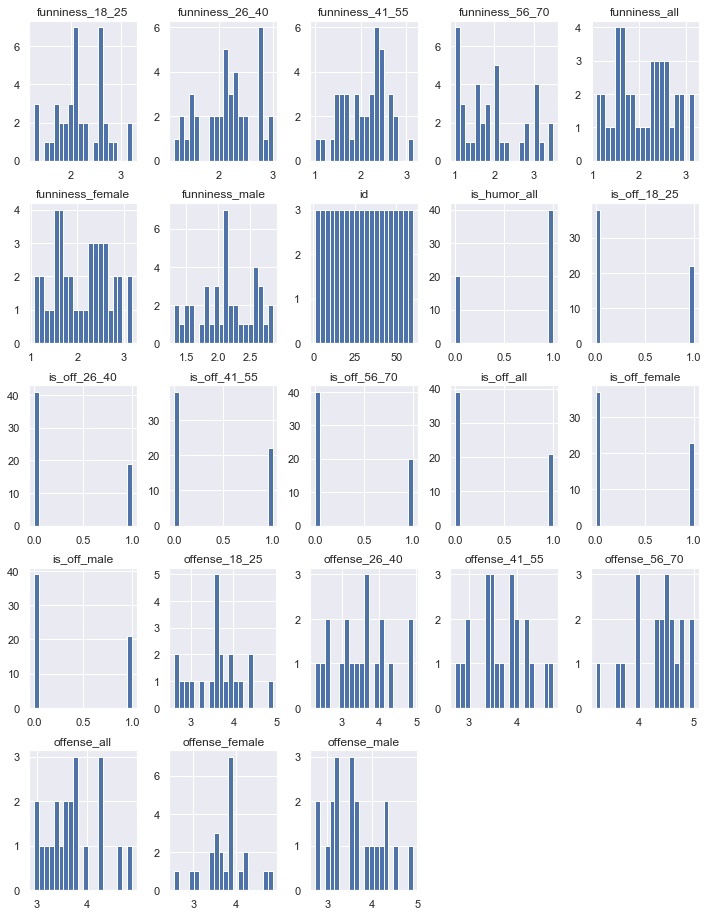

In [6]:
data.hist(bins = 20,figsize= (12,16));

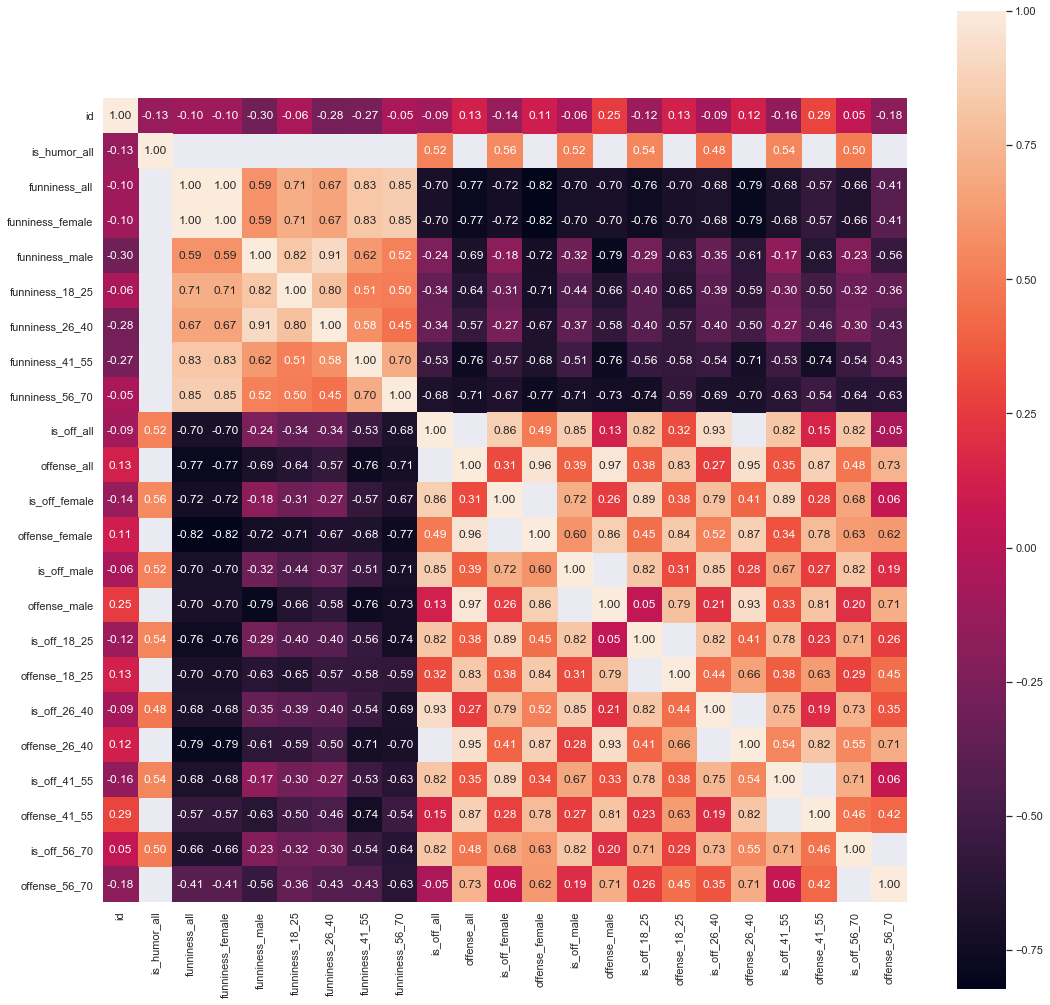

In [7]:
corr = data.corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f')
plt.show();

# Text Statistics

## Charaters in each sentence

### All sentences

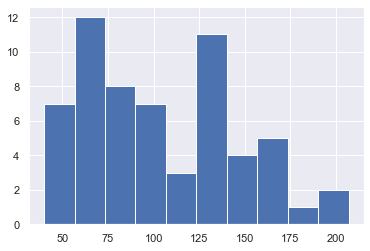

In [8]:
data['text'].str.len().hist()

### Sentences tagged humorous by all

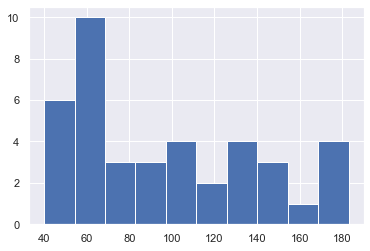

In [9]:
is_humor = data['is_humor_all']==1    
humor = data[is_humor]
humor['text'].str.len().hist()

### Sentences tagged not humorous

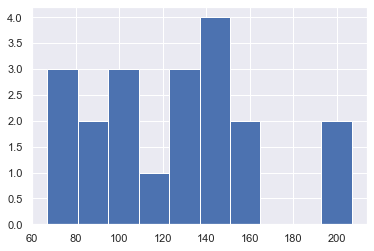

In [10]:
not_humor = data['is_humor_all']==0    
not_humor_df = data[not_humor]
not_humor_df['text'].str.len().hist()

## Words in each sentence

### All sentences

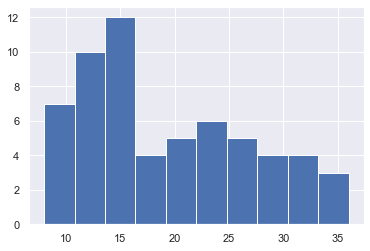

In [11]:
data['text'].str.split().map(lambda x: len(x)).hist()

### Sentences tagged humorous by all

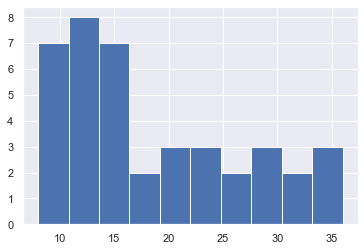

In [12]:
humor['text'].str.split().map(lambda x: len(x)).hist()

### Sentences tagged not humorous

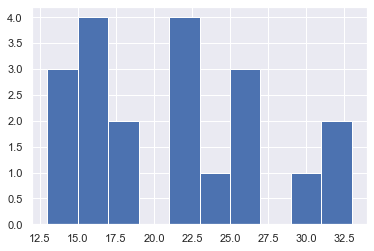

In [13]:
not_humor_df['text'].str.split().map(lambda x: len(x)).hist()

## Average word length in each sentence

### All Sentences

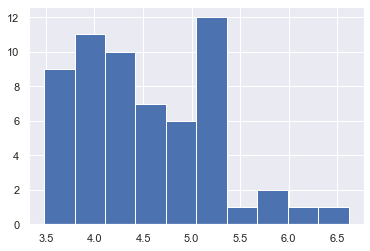

In [14]:
data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Sentences tagged humorous by all

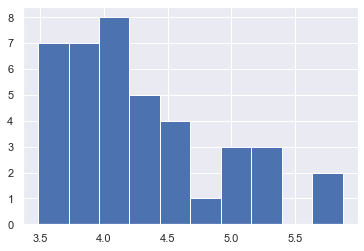

In [15]:
humor['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Sentences tagged not humorous

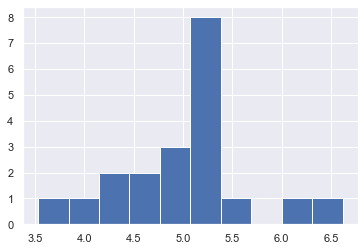

In [16]:
not_humor_df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

## Stopwords frequency

In [17]:
stop = set(stopwords.words('english'))

In [18]:
corpus = []
text = data['text'].str.split()
text = text.values.tolist()
corpus=[word for i in text for word in i]
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 15 artists>

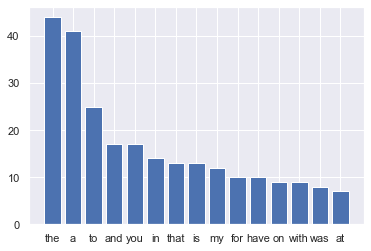

In [19]:
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y = zip(*top)
plt.bar(x,y)

## Most frequent words that are not stopwords

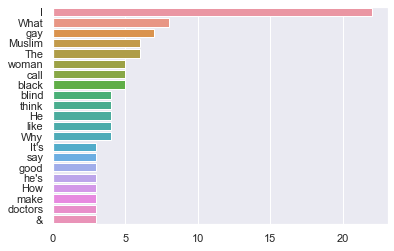

In [20]:
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

## ngrams

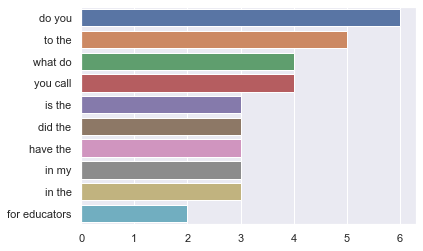

In [21]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]
top_n_bigrams = get_top_ngram(data['text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)


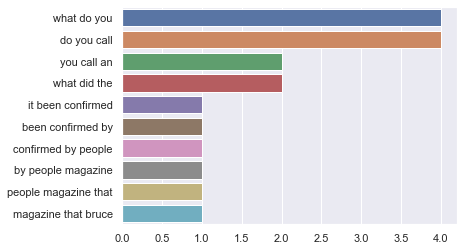

In [22]:
top_tri_grams=get_top_ngram(data['text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

## Topic Modeling using LDA

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KRajvel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
def preprocess_data(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for d in df['text']:
        words = [w for w in word_tokenize(d) if (w not in stop)]
        
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus
corpus = preprocess_data(data)

In [25]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [26]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.013*"girl" + 0.012*"Muslim" + 0.012*"Sunglasses" + 0.009*"What" + 0.009*"asked" + 0.009*"see" + 0.009*"Woman" + 0.009*"get" + 0.009*"taxi" + 0.009*"Today"'),
 (1,
  '0.021*"..." + 0.013*"What" + 0.013*"black" + 0.009*"like" + 0.009*"Muslim" + 0.009*"milk" + 0.009*"look" + 0.009*"really" + 0.009*"mine" + 0.009*"use"'),
 (2,
  '0.020*"The" + 0.020*"n\'t" + 0.020*"gay" + 0.014*"one" + 0.014*"would" + 0.012*"think" + 0.011*"black" + 0.011*"people" + 0.009*"day" + 0.007*"girlfriend"'),
 (3,
  '0.018*"woman" + 0.012*"\'ve" + 0.009*"blind" + 0.009*"doctor" + 0.009*"gay" + 0.006*"call" + 0.006*"say" + 0.006*"You" + 0.006*"make" + 0.006*"good"')]

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.084043  0.067600       1        1  33.549053
2     -0.122126  0.037306       2        1  26.846334
0      0.028404 -0.005871       3        1  20.273064
1      0.009679 -0.099035       4        1  19.331547, topic_info=           Term      Freq     Total Category  logprob  loglift
105         The  4.000000  4.000000  Default  30.0000  30.0000
207         n't  4.000000  4.000000  Default  29.0000  29.0000
113         gay  6.000000  6.000000  Default  28.0000  28.0000
123       black  3.000000  3.000000  Default  27.0000  27.0000
116         one  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
415      gotten  0.653305  1.735202   Topic4  -5.3058   0.6666
163       never  0.653093  2.333252   Topic4  -5.3062   0.3701
101       Every  0.653073  1.692427   Topic4  -5.3062   0.6912
121  Apparently  0.652957  1.692468   Topic4  -5.3064   0.6910
81         call  0.652870  3.504034   Topic4  -5.3065  -0.0369

[225 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
84        1  0.573557        're
84        3  0.573557        're
249       1  0.714900        've
249       3  0.238300        've
97        1  0.161573        ...
...     ...       ...        ...
11        4  0.166859      woman
155       2  0.673950      would
377       2  0.588019       year
377       3  0.588019       year
146       2  0.854254  yesterday

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

## Word cloud

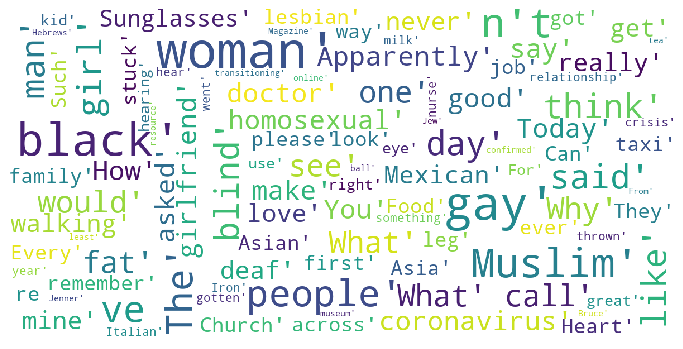

In [28]:
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(corpus)

## Text Sentiment - polarity

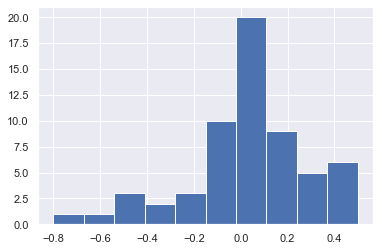

In [29]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
data['polarity_score'] = data['text'].apply(lambda x : polarity(x))
data['polarity_score'].hist()

<BarContainer object of 3 artists>

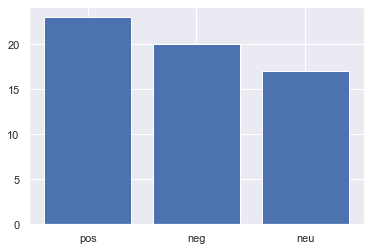

In [30]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
data['polarity'] = data['polarity_score'].map(lambda x: sentiment(x))
plt.bar(data.polarity.value_counts().index,data.polarity.value_counts())

In [31]:
data[data['polarity']=='pos']['text'].head()

0     It's been confirmed by People Magazine that Br...
2     From online museum resources on Asian art to E...
4     Muslim minority doctors first to die on front ...
5     5 Years ago today I asked a beautiful girl out...
12    The church apparently thinks that gay and lesb...
Name: text, dtype: object

In [32]:
data[data['polarity']=='neg']['text'].head()

3     Ignorance is bliss but i'd rather be stressed,...
10    What did the two tampons have in common? They ...
11    Every religion has violent people... ... The C...
13    Apparently I have a black person in my family ...
17    Why should you never play Uno with a Mexican? ...
Name: text, dtype: object

In [33]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KRajvel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<BarContainer object of 3 artists>

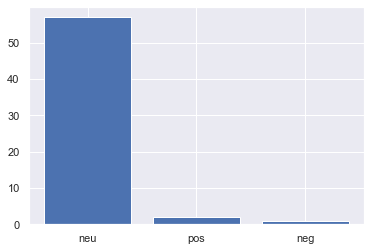

In [34]:
sid = SentimentIntensityAnalyzer()
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])
data['polarity'] = data['text'].map(lambda x: get_vader_score(x))
polarity = data['polarity'].replace({0:'neg',1:'neu',2:'pos'})
plt.bar(polarity.value_counts().index,polarity.value_counts())